In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data files

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"}
    self.n_words = 2

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r'([.!?])', r' \1', s)
  s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
  return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
  print("Reading lines...")

  lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    read().strip().split('\n')
  
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  else:
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

  return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am", "i m",
    "he is", "he s ",
    "she is", 'she s ',
    "you are", 'you re ',
    'we are', 'we re ',
    'they are', 'they re '
)

def filterPair(p):
  return len(p[0].split(' ')) < MAX_LENGTH and \
    len(p[1].split(' ')) < MAX_LENGTH and \
    p[1].startswith(eng_prefixes)

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  print(f'Read {len(pairs)} sentence pairs')
  pairs = filterPairs(pairs)
  print(f'Trimmed to {len(pairs)} sentence pairs')
  print('Counting words...')
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print('Counted words:')
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11051 sentence pairs
Counting words...
Counted words:
fra 4502
eng 2905
['ils sont similaires .', 'they re similar .']


# Seq2Seq - Encoder

In [8]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, 1, self.hidden_size).to(device)

# Seq2Seq - Decoder

In [9]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = F.log_softmax(self.out(output[0]))
    return output, hidden
  
  def init_hidden(self):
    return torch.zeros(1, 1, self.hidden_size).to(device)

# Seq2Seq Attention Decoder

In [10]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length

    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, 1, -1)
    embedded = self.dropout(embedded)

    attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)

    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights
  
  def init_hidden(self):
    return torch.zeros(1, 1, self.hidden_size).to(device)

# Traning

In [11]:
def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long).view(-1, 1).to(device)

def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return (input_tensor, target_tensor)

In [12]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
  encoder_hidden = encoder.init_hidden()
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size).to(device)

  loss = 0
  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

  decoder_input = torch.tensor([[SOS_token]]).to(device)
  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing:
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention \
      = decoder(decoder_input, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[di])
      decoder_input = target_tensor[di]
  else:
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention \
      = decoder(decoder_input, decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach() # detach from history as input
      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token:
        break

  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01):
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
  training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
  criterion = nn.NLLLoss()

  for iter in range(1, n_iters+1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
                 decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                   iter, iter / n_iters * 100, print_loss_avg))
      
    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0

  showPlot(plot_losses)

In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

# Evaluation

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.init_hidden()

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size).to(device)

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]]).to(device)

    decoder_hidden = encoder_hidden

    decoder_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs
      )
      decoder_attentions[di] = decoder_attention.data
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == EOS_token:
        decoder_words.append('<EOS>')
        break
      else:
        decoder_words.append(output_lang.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()

  return decoder_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

2m 3s (- 28m 43s) (5000 6%) 2.9316
3m 56s (- 25m 36s) (10000 13%) 2.3512
5m 50s (- 23m 22s) (15000 20%) 2.0521
7m 45s (- 21m 19s) (20000 26%) 1.8102
9m 39s (- 19m 19s) (25000 33%) 1.5973
11m 34s (- 17m 22s) (30000 40%) 1.4450
13m 29s (- 15m 25s) (35000 46%) 1.2829
15m 24s (- 13m 29s) (40000 53%) 1.1723
17m 22s (- 11m 35s) (45000 60%) 1.0473
19m 19s (- 9m 39s) (50000 66%) 0.9619
21m 16s (- 7m 44s) (55000 73%) 0.8711
23m 12s (- 5m 48s) (60000 80%) 0.7861
25m 7s (- 3m 51s) (65000 86%) 0.6966
27m 2s (- 1m 55s) (70000 93%) 0.6597
28m 58s (- 0m 0s) (75000 100%) 0.6017


In [21]:
evaluateRandomly(encoder1, attn_decoder1)

> tu as probablement soif .
= you re probably thirsty .
< you re probably thirsty . <EOS>

> je suis surpris d apprendre ca .
= i am surprised to learn this .
< i m not to to this . <EOS>

> je ne suis pas decourage .
= i m not discouraged .
< i m not dumb . <EOS>

> tu en es en partie responsable .
= you are in part responsible for it .
< you are in part responsible for it . <EOS>

> nous sommes votre dernier espoir .
= we re your last hope .
< we re your last hope . <EOS>

> je suis consciencieux .
= i m thorough .
< i m married . <EOS>

> vous n etes pas tom .
= you aren t tom .
< you aren t tom . <EOS>

> je ne suis pas une personne violente .
= i m not a violent person .
< i m not a violent person . <EOS>

> tu es pleine de ressources .
= you re resourceful .
< you re very resourceful . <EOS>

> j en ai marre de ce temps .
= i m fed up with this weather .
< i m sick of this weather . <EOS>



# Visualize attention

In [24]:
%matplotlib inline

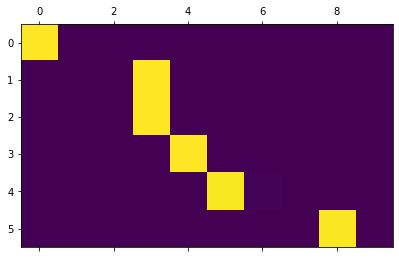

In [25]:
output_words, attentions = evaluate(encoder1, attn_decoder1, 'je suis trop froid .')
plt.matshow(attentions.numpy())

input =  elle a cinq ans de moins que moi .
output =  she s six years younger than me . <EOS>


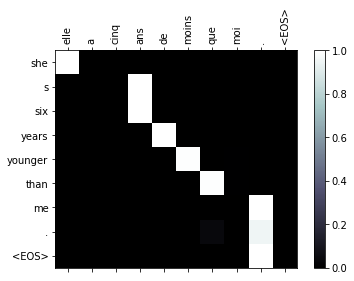

input =  elle est trop petit .
output =  she s too loud . <EOS>


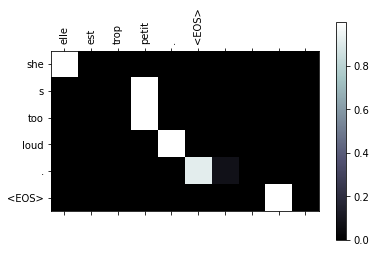

input =  je ne crains pas de mourir .
output =  i m not scared to die . <EOS>


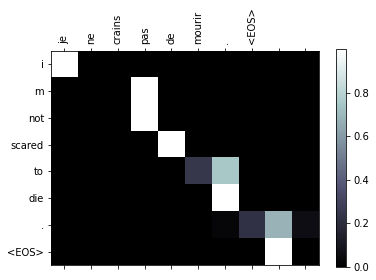

input =  c est un jeune directeur plein de talent .
output =  he s an talented young businessman . <EOS>


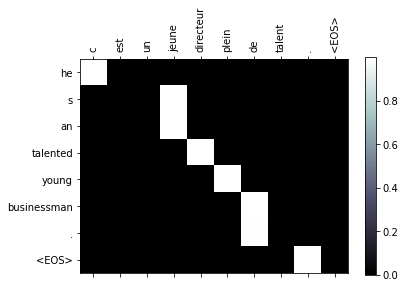

In [26]:
def showAttention(input_sentence, output_words, attentions):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.numpy(), cmap='bone')
  fig.colorbar(cax)

  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
  ax.set_yticklabels([''] + output_words)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def evaluateAndShowAttention(input_sentence):
  output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
  print('input = ', input_sentence)
  print('output = ', ' '.join(output_words))
  showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")